Import Dependencies

In [1]:
from pathlib import Path
from datasets import Dataset
import json
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
from collections import Counter

In [2]:
annotations_dir = Path("./train/annotations")
image_dir = Path("./train/images/")


In [3]:
annotation_files = list(map(str,list(annotations_dir.glob("*.json"))))

In [4]:
annotation_files = [file.replace('\\', '/') for file in annotation_files]
#annotation_files = [file.replace('train', 'train') for file in annotation_files]

In [5]:

ds = Dataset.from_dict({"path": annotation_files})

In [6]:
ds[0]

{'path': 'train/annotations/0000ae6cbdb1.json'}

In [7]:
with open("./train/annotations/0000ae6cbdb1.json") as file:
    data = json.load(file)

print(data.keys())
print("="*100)
print(data)

dict_keys(['source', 'chart-type', 'plot-bb', 'text', 'axes', 'data-series'])
{'source': 'generated', 'chart-type': 'vertical_bar', 'plot-bb': {'height': 137, 'width': 379, 'x0': 83, 'y0': 53}, 'text': [{'id': 0, 'polygon': {'x0': 53, 'x1': 412, 'x2': 412, 'x3': 53, 'y0': 7, 'y1': 7, 'y2': 30, 'y3': 30}, 'text': 'Estimates, 1950-2020: Total population by board age group, both sexes combined (thousands)-Population under age 15-64 for the year 1960', 'role': 'chart_title'}, {'id': 1, 'polygon': {'x0': 234, 'x1': 287, 'x2': 287, 'x3': 234, 'y0': 266, 'y1': 266, 'y2': 276, 'y3': 276}, 'text': 'COUNTRY', 'role': 'axis_title'}, {'id': 2, 'polygon': {'x0': 14, 'x1': 25, 'x2': 25, 'x3': 14, 'y0': 86, 'y1': 86, 'y2': 155, 'y3': 155}, 'text': 'POPULATION', 'role': 'axis_title'}, {'id': 3, 'polygon': {'x0': 30, 'x1': 74, 'x2': 74, 'x3': 30, 'y0': 47, 'y1': 47, 'y2': 58, 'y3': 58}, 'text': '1200000', 'role': 'tick_label'}, {'id': 4, 'polygon': {'x0': 30, 'x1': 74, 'x2': 74, 'x3': 30, 'y0': 69, 'y1

In [8]:
def plot_annotations(filename,ax):
    with open(filename,"r") as file:
        row = pd.json_normalize(json.load(file)).iloc[0]
    
    img = Image.open(image_dir/ Path(filename).with_suffix(".jpg").name)
    
    ax.imshow(img)
    
    bbox = patches.Rectangle(
        (row["plot-bb.x0"], row["plot-bb.y0"]),
        row["plot-bb.width"],
        row["plot-bb.height"],
        linewidth = 1,
        edgecolor = "r",
        facecolor = "none"
    )
    ax.add_patch(bbox)
    
    role2color = {
        'axis_title': "black",
        "chart_title": "green",
        "legend_label":"yellow",
        "other":"grey",
        "tick_grouping":"pink",
        "tick_label":"green",
    }
    
    for text in row['text']:
        polygon = text["polygon"]
        xs = np.array([v for k, v in polygon.items() if "x" in k])
        ys = np.array([v for k, v in polygon.items() if "y" in k])
        xy = np.vstack([xs, ys]).T
        text_polygon = patches.Polygon(xy, linewidth=1, edgecolor=role2color[text["role"]], facecolor="none")
        ax.add_patch(text_polygon)

    
    ax.axis("off")

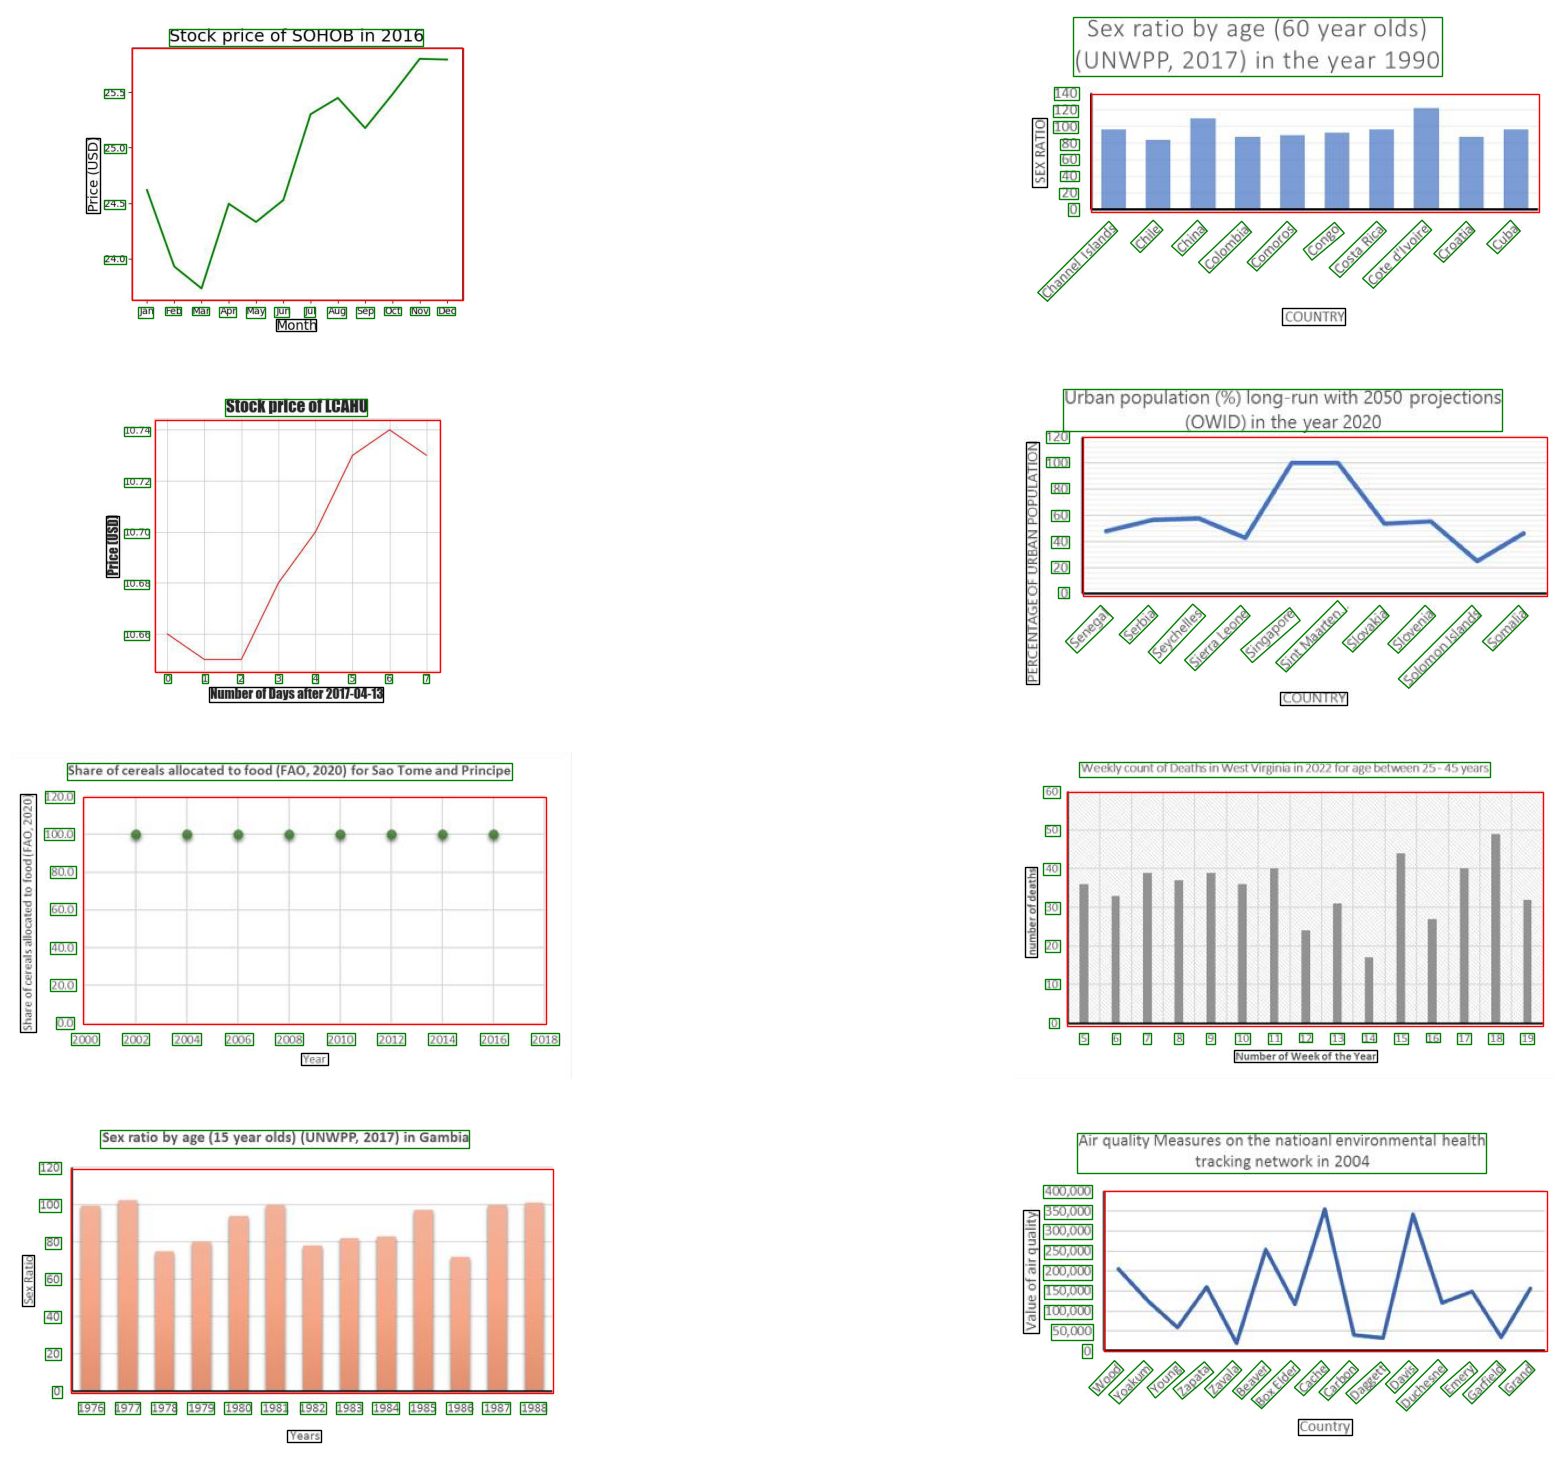

In [9]:
nrows, ncols = 4, 2
fig, ax = plt.subplots(nrows, ncols, figsize=(20, 15))
fig.tight_layout()
ax = ax.flatten()

idxs = np.random.randint(low=0, high=len(ds), size=nrows*ncols)

for i, idx in enumerate(idxs):
    plot_annotations(ds['path'] [idx], ax[i])
    
plt.savefig("annotated_examples.pdf", bbox_inches="tight")

In [10]:
len(ds)

60578

In [11]:
def chart_parse_json(batch):
    
    import json
    from collections import Counter
    
    X_START = "<x_start>"
    X_END = "<x_end>"
    Y_START = "<y_start>"
    Y_END = "<y_end>"
    
    gt_string = list()
    source_list = list()
    chart_list = list()
    x_list = list()
    y_list = list()
    
    for filename in batch["path"]:
        with open(filename,'r') as file:
            data = json.load(file)
        
        chart_type = data['chart-type']
        source_type = data['source']
        data_series = data['data-series']
        
        x, y = [], []
        
        for row in data_series:
            x.append(row['x'])       
            y.append(row['y'])  
            
        x = list(map(str,x))     
        y = list(map(str,y))     
    
        chart_token = f"<{chart_type}"
        ground_truth_string = chart_token+X_START+ ";".join(x)+X_END+Y_START+ ";".join(y)+Y_END
        
        gt_string.append(ground_truth_string)
        source_list.append(source_type)
        chart_list.append(chart_type)
        x_list.append(x)
        y_list.append(y)
        
    return {
        'source' : source_list,
        'chart' : chart_list,
        'x' : x_list,
        'y' : y_list,
        'ground_truth_string': gt_string
    }

In [12]:
ds_new = ds.map(
    chart_parse_json,
    batched=True,
    num_proc=4
)

Map (num_proc=4):   0%|          | 0/60578 [00:00<?, ? examples/s]

In [13]:
ds_new[0]

{'path': 'train/annotations/0000ae6cbdb1.json',
 'source': 'generated',
 'chart': 'vertical_bar',
 'x': ['Malawi',
  'Malaysia',
  'Maldives',
  'Mali',
  'Malta',
  'Martinique',
  'Mauritania',
  'Mauritius',
  'Mayotte',
  'Melanesia'],
 'y': ['837799.95244483',
  '960480.6137135166',
  '750170.9086814824',
  '697593.4824234738',
  '574912.8211547872',
  '452232.1598861007',
  '653778.9605418',
  '539861.2036494482',
  '417180.54238076165',
  '574912.8211547872'],
 'ground_truth_string': '<vertical_bar<x_start>Malawi;Malaysia;Maldives;Mali;Malta;Martinique;Mauritania;Mauritius;Mayotte;Melanesia<x_end><y_start>837799.95244483;960480.6137135166;750170.9086814824;697593.4824234738;574912.8211547872;452232.1598861007;653778.9605418;539861.2036494482;417180.54238076165;574912.8211547872<y_end>'}

In [14]:
print(Counter(list(ds_new['chart'])))
print("="*50)
print(Counter(list(ds_new['source'])))

Counter({'line': 24942, 'vertical_bar': 19189, 'scatter': 11243, 'dot': 5131, 'horizontal_bar': 73})
Counter({'generated': 59460, 'extracted': 1118})


In [15]:
class CFG:
    
    model_name = "naver-clova-ix/donut-base"

In [16]:
from transformers import (
    AutoProcessor,
    VisionEncoderDecoderConfig,
    VisionEncoderDecoderModel,
)

In [17]:
def get_config_processor_model(model_name):
    
    processor = AutoProcessor.from_pretrained(model_name)
    config = VisionEncoderDecoderConfig.from_pretrained(model_name)
    model = VisionEncoderDecoderModel.from_pretrained(model_name)
    
    return model, config, processor
    
    

In [18]:
model, config, processor = get_config_processor_model(CFG.model_name)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates